In [326]:
# Imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output
import warnings

### Load df

In [328]:
df = pd.read_csv("fremont_df.csv")

### EDA

In [330]:
df.shape

(111696, 4)

In [331]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111696 entries, 0 to 111695
Data columns (total 4 columns):
 #   Column                                                              Non-Null Count   Dtype  
---  ------                                                              --------------   -----  
 0   Date                                                                111696 non-null  object 
 1   Fremont Bridge Sidewalks, south of N 34th St Total                  111596 non-null  float64
 2   Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk  111596 non-null  float64
 3   Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk  111596 non-null  float64
dtypes: float64(3), object(1)
memory usage: 3.4+ MB


In [332]:
df.describe()

,"Fremont Bridge Sidewalks, south of N 34th St Total","Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk","Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk"
count,111596.000000,111596.000000,111596.000000
mean,106.383643,45.210778,61.172865
std,131.723155,58.717869,82.477519
min,0.000000,0.000000,0.000000
25%,13.000000,5.000000,7.000000
50%,60.000000,26.000000,33.000000
75%,146.000000,63.000000,81.000000
max,1097.000000,667.000000,850.000000


#### Convert column names

In [334]:
df.columns = ['Date', 'Total', 'West', 'East']

#### Check for nulls

In [336]:
df.isnull().sum()

Date       0
Total    100
West     100
East     100
dtype: int64

In [337]:
df[df.isnull().any(axis=1)]

,Date,Total,West,East
3805,03/10/2013 02:00:00 AM,NaN,NaN,NaN
6116,06/14/2013 09:00:00 AM,NaN,NaN,NaN
6117,06/14/2013 10:00:00 AM,NaN,NaN,NaN
12541,03/09/2014 02:00:00 AM,NaN,NaN,NaN
21277,03/08/2015 02:00:00 AM,NaN,NaN,NaN
...,...,...,...,...
111691,06/30/2025 07:00:00 PM,NaN,NaN,NaN
111692,06/30/2025 08:00:00 PM,NaN,NaN,NaN
111693,06/30/2025 09:00:00 PM,NaN,NaN,NaN
111694,06/30/2025 10:00:00 PM,NaN,NaN,NaN


In [338]:
df = df.dropna() 

#### Creating breakdown of columns for visualization

In [340]:
df['Date'] = pd.to_datetime(df['Date'])

C:\Users\conor\AppData\Local\Temp\ipykernel_20044\2394721818.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [341]:
df['Hour'] = df['Date'].dt.hour
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Weekday'] = df['Date'].dt.day_name()
df['Weekend'] = df['Weekday'].isin(['Saturday', 'Sunday'])

### Initial Visualization

In [343]:
# Group by Month & Year
monthly = df.groupby([df['Year'], df['Month']])['Total'].sum().reset_index()

In [344]:
# Create df column for plotting
monthly['Date'] = pd.to_datetime(monthly[['Year', 'Month']].assign(DAY=1))

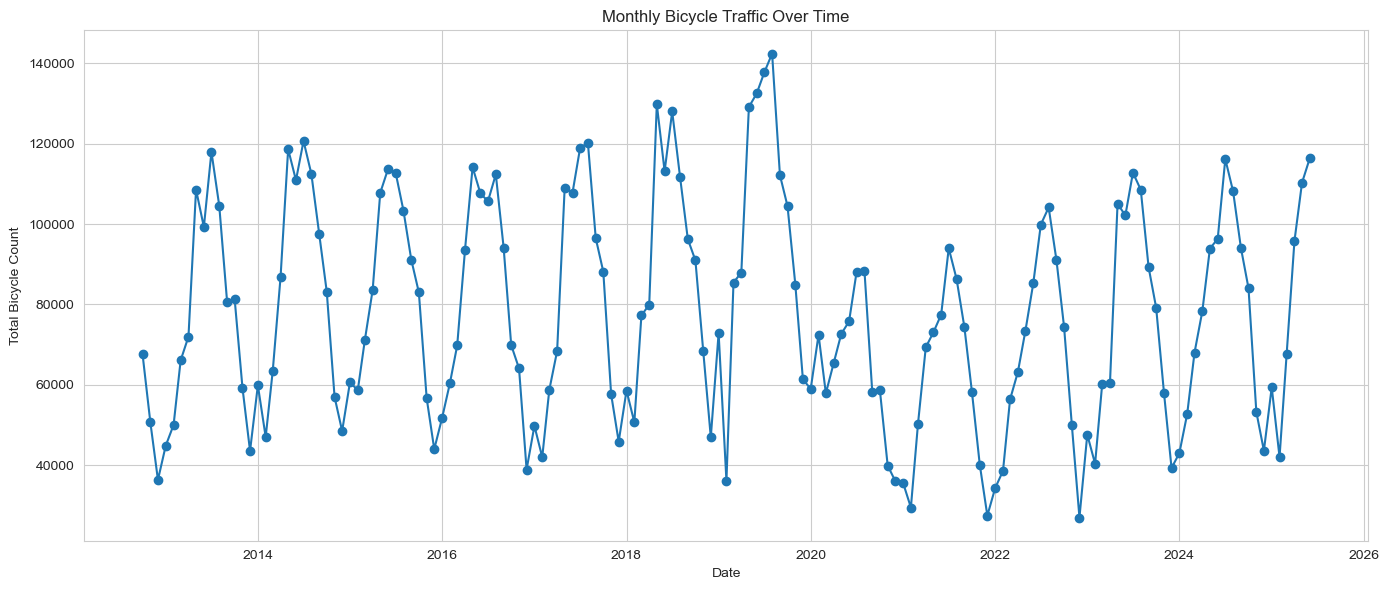

In [345]:
# Plot of monthly bucycle traffic
plt.figure(figsize=(14,6))
plt.plot(monthly['Date'], monthly['Total'], marker='o', linestyle='-')
plt.title('Monthly Bicycle Traffic Over Time')
plt.xlabel('Date')
plt.ylabel('Total Bicycle Count')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Weekday vs weekend Breakdown

In [347]:
# Group by Weekday
weekday_totals = df.groupby('Weekday')['Total'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

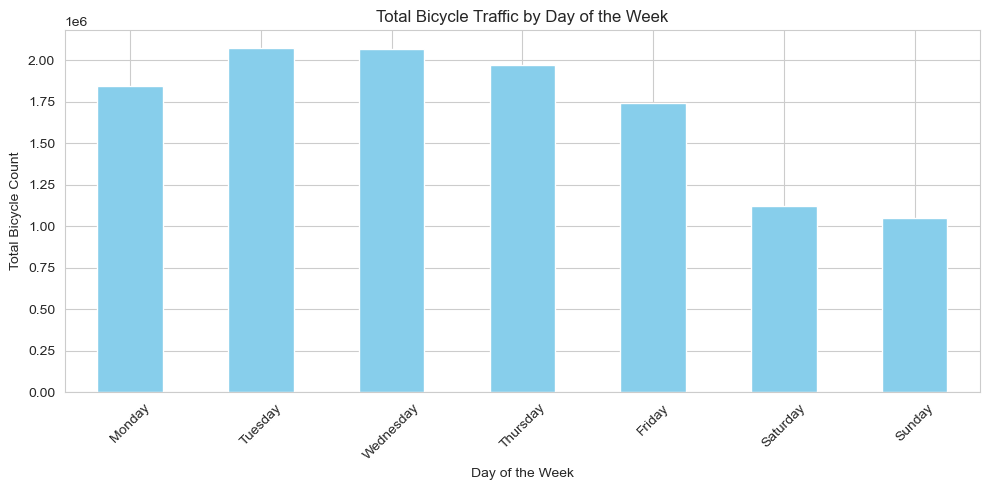

In [348]:
# Plot
plt.figure(figsize=(10,5))
weekday_totals.plot(kind='bar', color='skyblue')
plt.title('Total Bicycle Traffic by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Bicycle Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Hourly Directional Trends [East vs West]

In [350]:
# Group by hour, average counts
hourly = df.groupby('Hour')[['East', 'West']].mean()

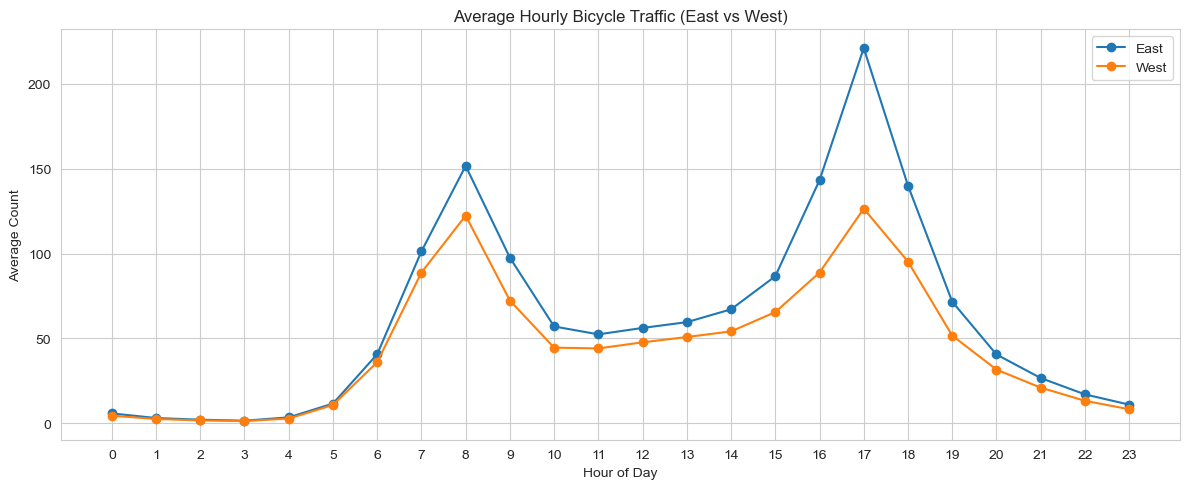

In [351]:
# Plot
hourly.plot(figsize=(12,5), marker='o')
plt.title('Average Hourly Bicycle Traffic (East vs West)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Count')
plt.grid(True)
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

#### Hourly Trends by Weekday vs Weekend

In [353]:
# Create a 'WeekType' column
df['WeekType'] = df['Weekend'].map({True: 'Weekend', False: 'Weekday'})

In [354]:
# Group by WeekType and Hour, then average total counts
hourly_trend = df.groupby(['WeekType', 'Hour'])[['East', 'West']].mean()

In [355]:
# Sum East + West to get total sidewalk use
hourly_trend['Total'] = hourly_trend['East'] + hourly_trend['West']

In [356]:
# Reset index for plotting
hourly_trend = hourly_trend.reset_index()

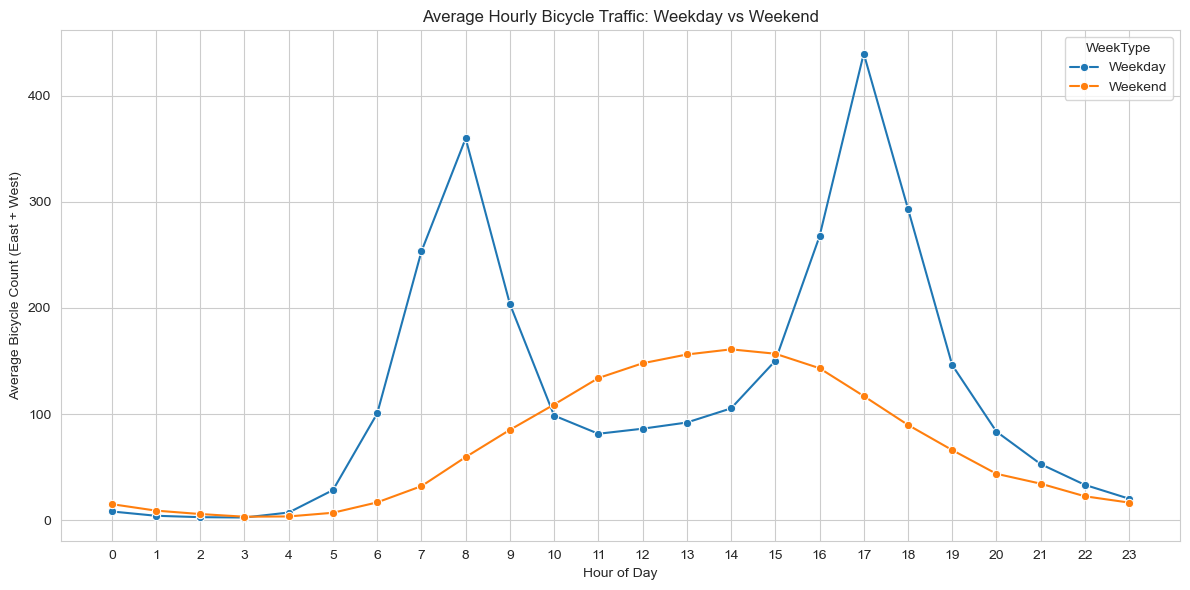

In [357]:
# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=hourly_trend, x='Hour', y='Total', hue='WeekType', marker='o')
plt.title('Average Hourly Bicycle Traffic: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Average Bicycle Count (East + West)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

#### YoY trend

In [359]:
yearly_counts = df.groupby('Year')['Total'].sum().reset_index()

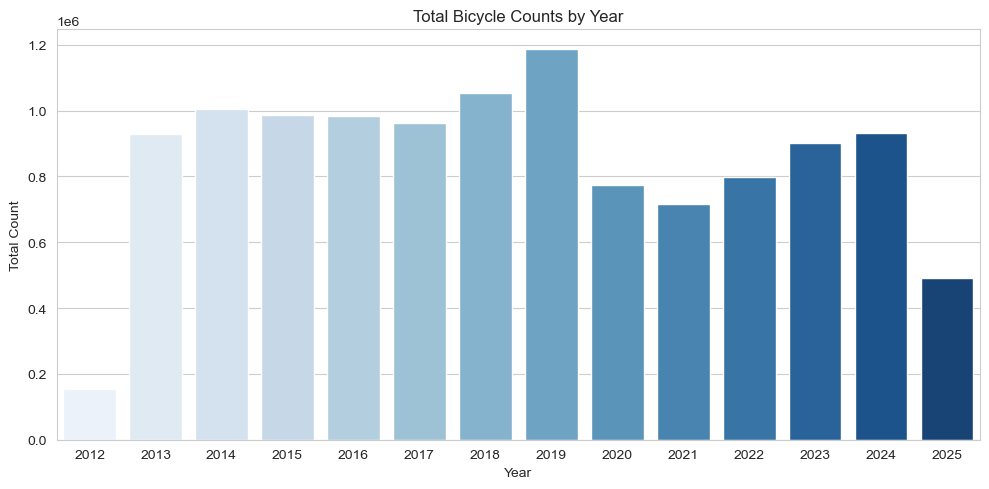

In [360]:
# Plot
plt.figure(figsize=(10,5))
sns.barplot(data=yearly_counts, x='Year', y='Total', palette='Blues')
plt.title('Total Bicycle Counts by Year')
plt.ylabel('Total Count')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

#### Heatmap: Average Hour vs Day

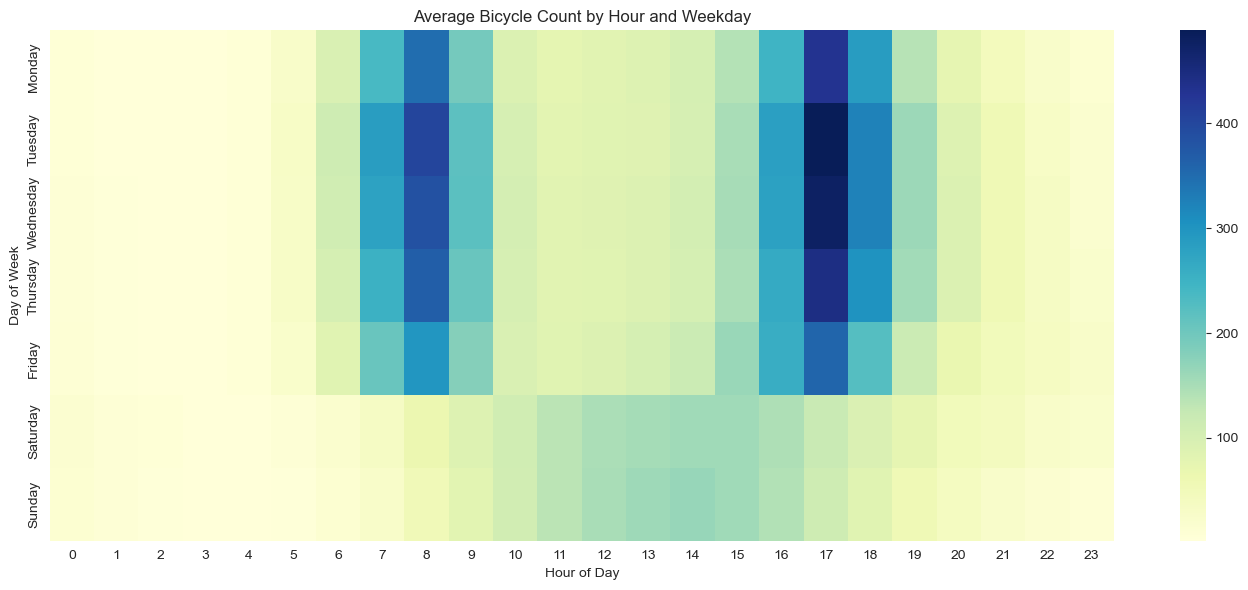

In [362]:
heatmap_data = df.pivot_table(index='Weekday', columns='Hour', values='Total', aggfunc='mean')
# Order weekdays
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(ordered_days)

plt.figure(figsize=(14,6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False)
plt.title('Average Bicycle Count by Hour and Weekday')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

#### Dashboard Building

In [364]:
# Make  plots display
sns.set_style("whitegrid")

In [365]:
# Monthly Bicycle Traffic Over Time
def plot_monthly_traffic():
    with output1:
        clear_output(wait=True)
        warnings.simplefilter(action='ignore', category=FutureWarning)
        monthly_data = df.resample('ME', on='Date').sum()        
        plt.figure(figsize=(12, 5))
        plt.plot(monthly_data.index, monthly_data['Total'], marker='o')
        plt.title("Monthly Bicycle Traffic Over Time")
        plt.xlabel("Date")
        plt.ylabel("Total Bicycle Count")
        plt.tight_layout()
        plt.show()

In [366]:
# Total Bicycle Traffic by Day of the Week
def plot_dayofweek_traffic():
    with output2:
        clear_output(wait=True)
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        weekday_agg = df.groupby('Weekday')['Total'].sum().reindex(day_order)
        plt.figure(figsize=(10, 5))
        sns.barplot(x=weekday_agg.index, y=weekday_agg.values, color="skyblue")
        plt.title("Total Bicycle Traffic by Day of the Week")
        plt.xlabel("Day of the Week")
        plt.ylabel("Total Bicycle Count")
        plt.tight_layout()
        plt.show()

In [367]:
# Average Hourly Bicycle Traffic (East vs West)
def plot_hourly_direction():
    with output3:
        clear_output(wait=True)
        hourly_avg = df.groupby('Hour')[['East', 'West']].mean()
        plt.figure(figsize=(12, 5))
        plt.plot(hourly_avg.index, hourly_avg['East'], marker='o', label='East')
        plt.plot(hourly_avg.index, hourly_avg['West'], marker='o', label='West')
        plt.title("Average Hourly Bicycle Traffic (East vs West)")
        plt.xlabel("Hour of Day")
        plt.ylabel("Average Count")
        plt.legend()
        plt.tight_layout()
        plt.show()

In [368]:
# Average Hourly Bicycle Traffic: Weekday vs Weekend
def plot_hourly_weektype():
    with output4:
        clear_output(wait=True)
        df['WeekType'] = df['Weekend'].map({True: 'Weekend', False: 'Weekday'})
        weektype_hourly = df.groupby(['Hour', 'WeekType'])['Total'].mean().unstack()
        plt.figure(figsize=(12, 5))
        plt.plot(weektype_hourly.index, weektype_hourly['Weekday'], marker='o', label='Weekday')
        plt.plot(weektype_hourly.index, weektype_hourly['Weekend'], marker='o', label='Weekend')
        plt.title("Average Hourly Bicycle Traffic: Weekday vs Weekend")
        plt.xlabel("Hour of Day")
        plt.ylabel("Average Bicycle Count (East + West)")
        plt.legend()
        plt.tight_layout()
        plt.show()

In [369]:
# Total Bicycle Counts by Year
def plot_yearly_totals():
    with output5:
        clear_output(wait=True)
        yearly_totals = df.groupby('Year')['Total'].sum()
        plt.figure(figsize=(10, 5))
        sns.barplot(x=yearly_totals.index, y=yearly_totals.values, palette="Blues")
        plt.title("Total Bicycle Counts by Year")
        plt.xlabel("Year")
        plt.ylabel("Total Count")
        plt.tight_layout()
        plt.show()

In [370]:
# Average Bicycle Count by Hour and Weekday (Heatmap)
def plot_heatmap():
    with output6:
        clear_output(wait=True)
        pivot_table = df.pivot_table(index='Weekday', columns='Hour', values='Total', aggfunc='mean')
        ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        pivot_table = pivot_table.reindex(ordered_days)
        plt.figure(figsize=(14, 6))
        sns.heatmap(pivot_table, cmap="YlGnBu")
        plt.title("Average Bicycle Count by Hour and Weekday")
        plt.xlabel("Hour of Day")
        plt.ylabel("Day of Week")
        plt.tight_layout()
        plt.show()

In [371]:
# Output areas for the six charts
output1 = widgets.Output()
output2 = widgets.Output()
output3 = widgets.Output()
output4 = widgets.Output()
output5 = widgets.Output()
output6 = widgets.Output()

In [372]:
header = widgets.HTML(
    value="<h1 style='text-align:center;'>Fremont Bridge Bicycle Dashboard</h1>",
    layout=widgets.Layout(margin='0 0 20px 0')
)

year_slider = widgets.IntRangeSlider(
    value=[2013, 2024],
    min=2012,
    max=2025,
    step=1,
    description='Year Range:',
    continuous_update=False,
    layout=widgets.Layout(width='95%')
)

week_filter = widgets.ToggleButtons(
    options=['All', 'Weekday', 'Weekend'],
    value='All',
    description='Traffic Type:',
)

side_filter = widgets.Dropdown(
    options=['Total', 'East Sidewalk', 'West Sidewalk'],
    value='Total',
    description='Direction:',
    layout=widgets.Layout(width='50%')
)

filters = widgets.VBox([
    year_slider,
    widgets.HBox([week_filter, side_filter]),
], layout=widgets.Layout(margin='20px 0'))

charts_row1 = widgets.HBox([output1, output2])
charts_row2 = widgets.HBox([output3, output4])
charts_row3 = widgets.HBox([output5, output6])

dashboard = widgets.VBox([
    header,
    filters,
    charts_row1,
    charts_row2,
    charts_row3
])

display(dashboard)
